2. Решить задачу object detection при помощи SSD на датасете https://github.com/Shenggan/BCCD_Dataset
- Реализацию SSD можно посмотреть тут https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
- Статья по SSD https://d2l.ai/chapter_computer-vision/ssd.html



In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import numpy as np
from math import sqrt
import pandas as pd
import time
import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision as tv

from torchvision.models.detection import ssdlite320_mobilenet_v3_large

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Каждое предсказание состоит из граничного поля и 21 балла для каждого класса
#(один дополнительный класс для отсутствия объекта)
np.random.seed(21)
torch.manual_seed(21);
#индексы картинок, на которых будем тестироваться
test = [0,2,14,17,28,29,30]

Датасет

In [63]:
class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root='/content/drive/MyDrive/BCCD_Dataset-master/', trans=None):
        super()
        self.root = root
        # данные, подготовленные с помощью скрипта export.py
        self.pds = pd.read_csv(os.path.join(root,"test.csv"))
        self.classes = ['Background'] + list(self.pds.cell_type.unique())
        self.classes_idx = {w: i for i, w in enumerate(self.classes)}
        #выполняем нормализацию
        self.transforms = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])
        self.imgs = self.pds.filename.unique()

    def get_image(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        return img

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        x = self.pds
        x = x[x.filename == filename]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.classes_idx[x[i,1]]
        labels  = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)
        boxes = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(x),), dtype=torch.int64)


        img = self.transforms(img).to(device)

        return img, {'boxes':boxes, 'labels':labels}

    def __len__(self):
        return len(self.imgs)

In [64]:
#анализз датасета
data = pd.read_csv('/content/drive/MyDrive/BCCD_Dataset-master/test.csv', delimiter = ',')
data.head(5)

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,RBC,63,169,237,336
3,BloodImage_00000.jpg,RBC,214,320,362,461
4,BloodImage_00000.jpg,RBC,414,506,352,445


In [66]:
data.info

<bound method DataFrame.info of                   filename  cell_type  xmin  xmax  ymin  ymax
0     BloodImage_00000.jpg        WBC   260   491   177   376
1     BloodImage_00000.jpg        RBC    78   184   336   435
2     BloodImage_00000.jpg        RBC    63   169   237   336
3     BloodImage_00000.jpg        RBC   214   320   362   461
4     BloodImage_00000.jpg        RBC   414   506   352   445
...                    ...        ...   ...   ...   ...   ...
4883  BloodImage_00410.jpg  Platelets   239   291   275   321
4884  BloodImage_00410.jpg  Platelets   121   189   260   320
4885  BloodImage_00410.jpg  Platelets    57   104   119   167
4886  BloodImage_00410.jpg  Platelets     1    29   286   327
4887  BloodImage_00410.jpg        WBC   367   611   166   394

[4888 rows x 6 columns]>

In [67]:
data.isnull().value_counts()

,,,,,,count
filename,cell_type,xmin,xmax,ymin,ymax,
False,False,False,False,False,False,4888


Модель

In [68]:
import torchvision

In [69]:
model = torchvision.models.detection.ssd300_vgg16(pretrained = True) # weights='DEFAULT',
ds = BCCDDataset()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dm %2ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [71]:
batch_size = 50
eps = 10



In [73]:
model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
start = time.time()
# Кол-во эпох

# Длина датасета на трейне
trn=list(set(range(len(ds)))-set(test))
for ep in range(eps):
    perm = np.random.permutation(trn) # случайный порядок обработки элементов во время обучения модели
    i = 0 # счетчик кол-ва обработанных батчей
    # Инициализируем функции потерь
    l0=0
    l1=0
    l2=0
    ln=0
    while True:
        features=[]
        targets=[]
        trainer.zero_grad()
        # Обработка частями по batch_size
        for j in range(batch_size):
            if i >= len(perm):
                break
            # считываем случайную строку из ds
            p,t = ds[perm[i]]
            features.append(p)
            targets.append(t)
            i +=1
        pred = model(features,targets)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
        loss.backward()
        trainer.step()
        # Здесь накапливается функция потерь по регрессии bounding boxes
        l1 += pred['bbox_regression'].item()
        # здесь ф-я потерь по классификации
        l2 += pred['classification'].item()
        # здесь суммарные потери
        l0 += loss.item()
        ln+=1 # Кол-во обработанных батчей
        if i >= len(perm):
            break
    pc = (ep + 1) / eps
    print('%s (%2d %3d%%) %8.4f %8.4f %8.4f' %
          (timeSince(start, pc),ep,pc*100,l0/ln,l1/ln,l2/ln))

 8m 16s (- 74m 28s) ( 0  10%)  55.8485   1.4905  11.4142
16m  3s (- 64m 13s) ( 1  20%)  28.0421   1.0645   5.2805
23m 50s (- 55m 37s) ( 2  30%)  17.7401   0.8351   3.7730
31m 36s (- 47m 24s) ( 3  40%)  13.5018   0.7264   2.9500
39m 20s (- 39m 20s) ( 4  50%)  12.0865   0.6821   2.7775
47m  3s (- 31m 22s) ( 5  60%)  10.9111   0.6495   2.4673
54m 48s (- 23m 29s) ( 6  70%)   9.8498   0.6120   2.2888
62m 24s (- 15m 36s) ( 7  80%)   8.3476   0.5584   2.0917
70m  3s (-  7m 47s) ( 8  90%)   7.6954   0.5327   1.9889
77m 42s (-  0m  0s) ( 9 100%)   7.2915   0.5119   2.0446


loss на каждой эпохе снижается, но после остается высоким. 

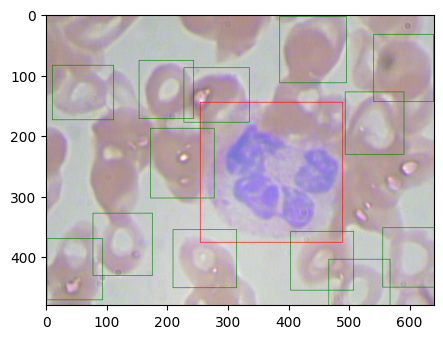

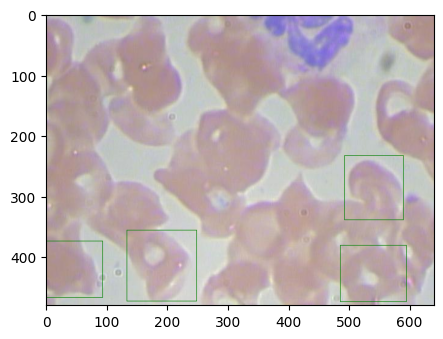

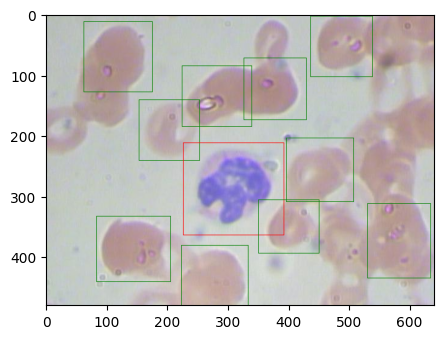

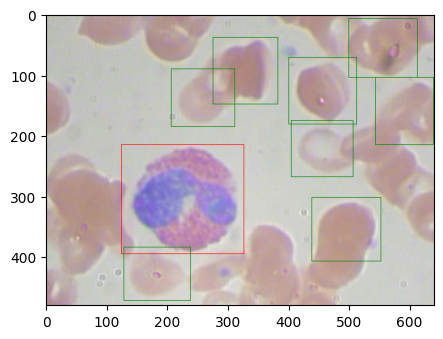

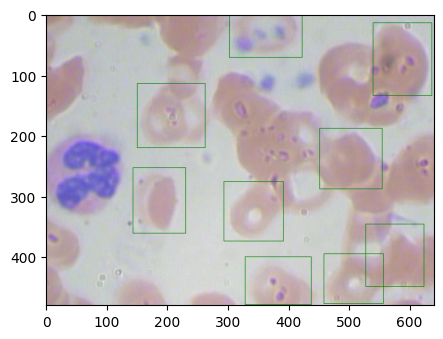

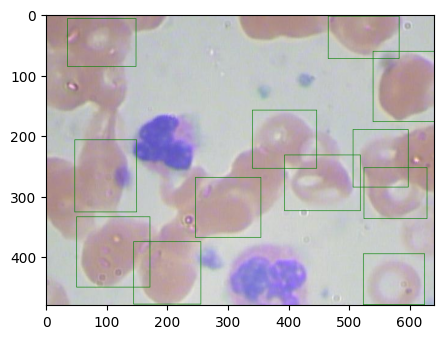

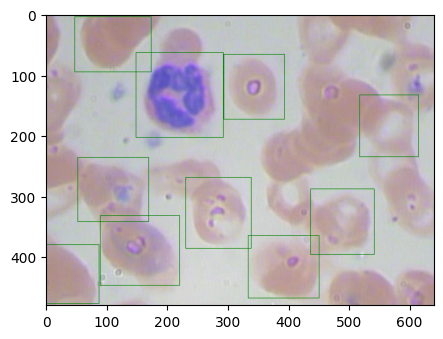

In [74]:
model.eval()
for i in test:
    p,t = ds[i]
    outputs = model([p])
    img = ds.get_image(i)
    draw = ImageDraw.Draw(img)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()
    boxes = outputs[0]['boxes'].detach().cpu().numpy()

    for i,box in enumerate(boxes):
        if scores[i] > 0.5 :
            c = classes[i]
            c = c if c < 4 else 0
            cl = ['black','red','green','blue']
            draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.figure(figsize=(5, 5))
    plt.imshow(img)

Из 7 тестовых картинок объект обнаружен на 3-х. SSD делает много прогнозов  для лучшего покрытия местоположения, но многие прогнозы не содержат объектов. Мелкие объекты не определяются.